# **1. Introduction**
The Auto-MPG dataset contains technical specifications of a variety of cars used on a daily basis in the real world. The dataset contains the fuel consumption of the car along with the technical specifications of the car, which makes it perfect for determining an automobile's fuel consumption when just a few specifications are provided.

In this project we are hoping to find the patterns of the specifications that influence its fuel consumption and accurately predict the fuel consumption when only the specifications are known.

---


# **2. Dataset Description**
**Dataset Source Link**

https://www.kaggle.com/datasets/uciml/autompg-dataset?resource=download

**Context**

The Auto-MPG dataset contains technical specifications of cars. The dataset is downloaded from UCI Machine Learning Repository.

**Content**

*   Number of Instances: 398
*   Number of Attributes: 9

**Attributes**


1. mpg: Miles per gallon (target variable)
2. cylinders: Number of cylinders in the car engine (multi-valued discrete)
3. displacement: Engine displacement in cubic inches (continuous)
4. horsepower: Engine horsepower (continuous; has missing values)
5. weight: Car weight in pounds (continuous)
6. acceleration: Time to accelerate from 0 to 60 mph (continuous)
7. model year: Year the car model was released (multi-valued discrete)
8. origin: Country of origin (1: USA, 2: Europe, 3: Japan)
9. car name: String identifier for the car model

---



# **3. Importing Libraries**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder

---
# **4. Importing the Dataset**

In [4]:
import kagglehub
path = kagglehub.dataset_download("uciml/autompg-dataset")
print("Path to dataset files:", path)

100%|██████████| 6.31k/6.31k [00:00<00:00, 8.91MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/autompg-dataset/versions/3


In [5]:
import pandas as pd

df = pd.read_csv('/root/.cache/kagglehub/datasets/uciml/autompg-dataset/versions/3/auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


---
# **5. Data Preprocessing**

*  ## 5.1. Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [7]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [8]:
df.dtypes

,0
mpg,float64
cylinders,int64
displacement,float64
horsepower,object
weight,int64
acceleration,float64
model year,int64
origin,int64
car name,object


* ## 5.2. Handling Missing Values

In [9]:
print(df.isnull().sum())
df.replace('?', pd.NA, inplace=True)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [10]:
df.dropna(subset=['horsepower'], inplace=True)
print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


* ## 5.3. Handling Outliers

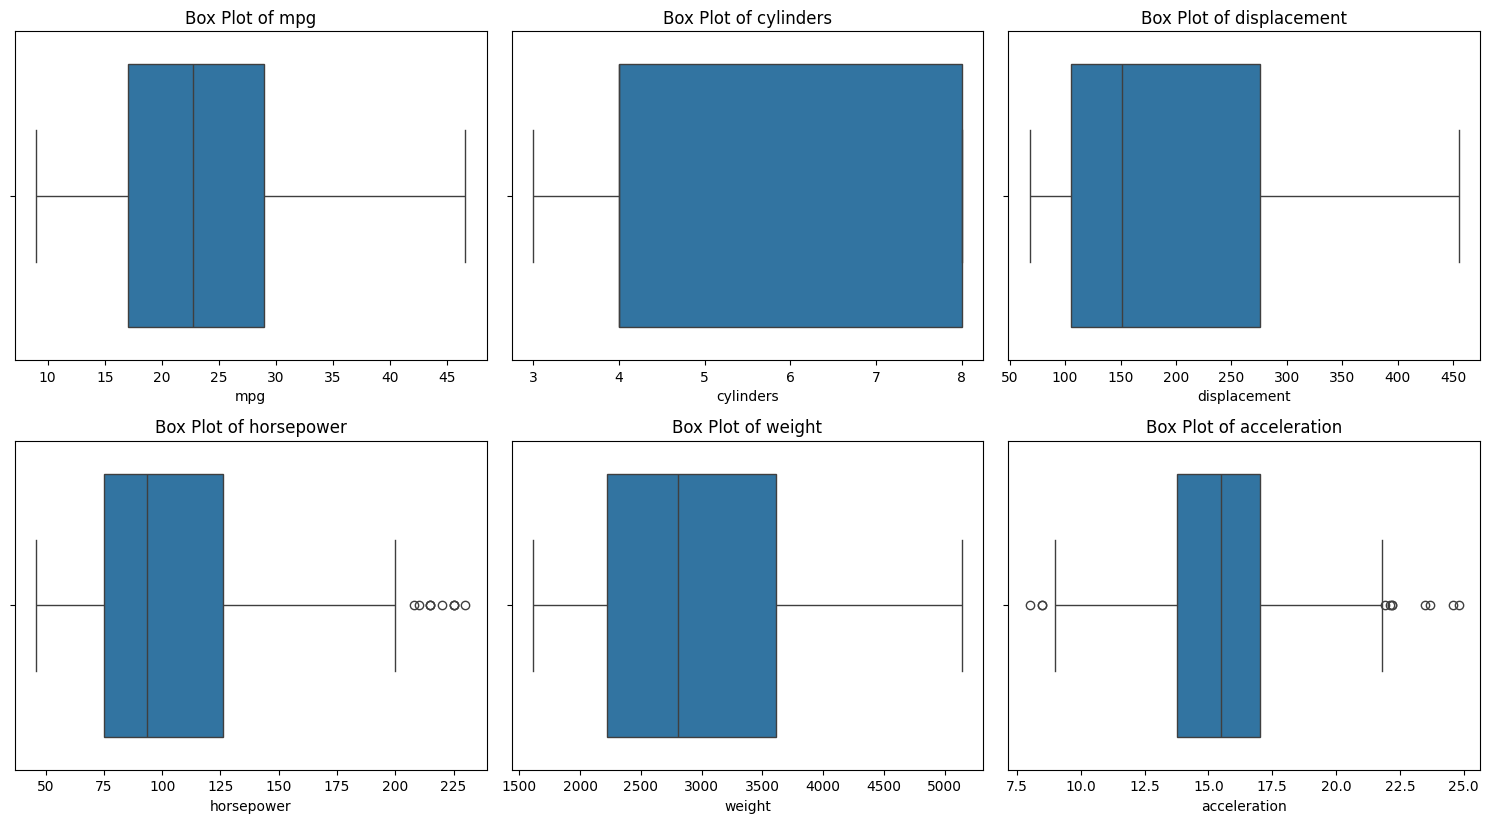


Number of Duplicates: 0


In [11]:
numerical_columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']

plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.tight_layout()

plt.show()

print(f"\nNumber of Duplicates: {df.duplicated().sum()}")

In [12]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']:
    df = remove_outliers_iqr(df, col)

print(f"Dataset after removing outliers: {df.shape}\n")

Dataset after removing outliers: (373, 9)



* ## 5.4. Feature Selection


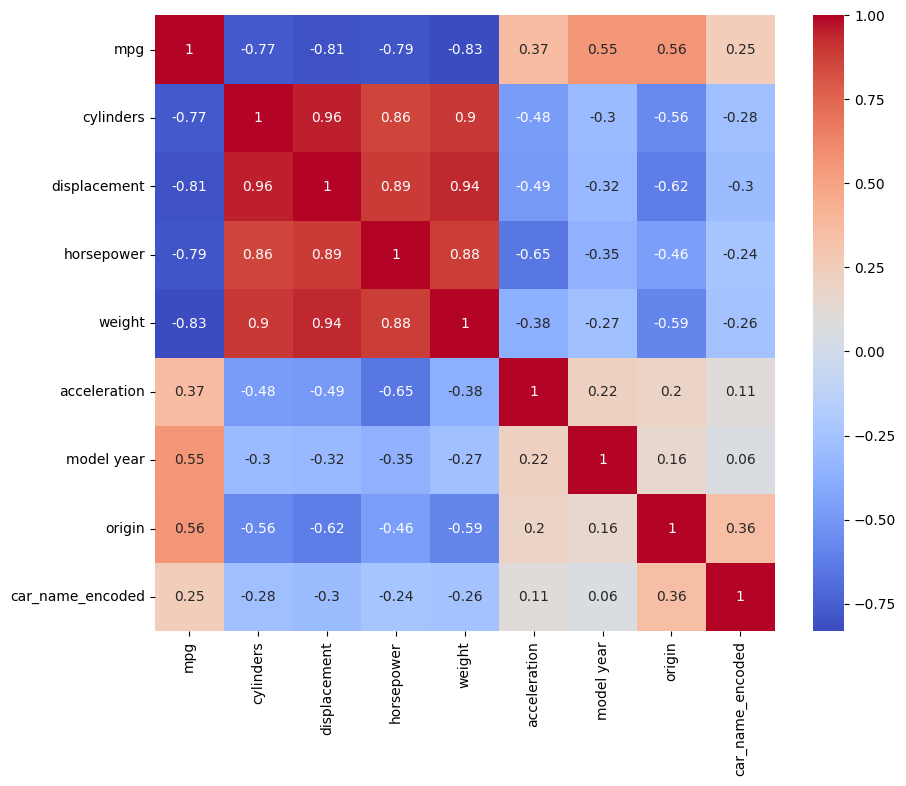

In [13]:
# Encode the 'car name' column
df['car_name_encoded'] = LabelEncoder().fit_transform(df['car name'])

# Select only numeric columns, including the encoded 'car name'
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute and plot the correlation matrix
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


**Target Variable**
- **mpg**: Miles per gallon (continuous variable)

**Features Overview**

| Feature         | Type                    | Suitability     | Description                                                                                  |
|------------------|-------------------------|------------------|----------------------------------------------------------------------------------------------|
| **Cylinders**    | Multi-valued discrete   | High             | Number of cylinders in the engine; generally, more cylinders lead to lower mpg.            |
| **Displacement** | Continuous              | High             | Engine displacement in cubic inches; larger engines typically consume more fuel, lowering mpg. |
| **Horsepower**   | Continuous              | High (with caution) | Engine horsepower; more powerful engines may consume more fuel, affecting mpg. Missing values must be handled. |
| **Weight**       | Continuous              | High             | Car weight in pounds; heavier cars usually have worse fuel efficiency, leading to lower mpg. |
| **Acceleration** | Continuous              | Moderate         | Time to accelerate from 0 to 60 mph; indirectly related to engine performance and efficiency. |
| **Model Year**   | Multi-valued discrete   | Moderate         | Year the car model was released; reflects advancements in fuel efficiency over time.        |
| **Origin**       | Categorical (1: USA, 2: Europe, 3: Japan) | Moderate         | Country of origin; can influence design and fuel efficiency.                                  |
| **Car Name**     | String identifier       | Low              | Identifier for the car model; generally not suitable for modeling unless transformed into categorical features. |

**Conclusion**

Based on the above relavance for mpg we exclude Car name from this set of features

In [14]:
df.drop(columns=['car name'], inplace=True)

# **6. Train-Test Split, Feature Scaling, and Ridge Regression Model Evaluation**

We will divide the data into:
- **60% for Training**
- **20% for Cross-Validation**
- **20% for Testing**


In [15]:
# Step 1: Train-Test Split
train_temp, test_set = train_test_split(df, test_size=0.2, random_state=17)
train_set, cross_val_set = train_test_split(train_temp, test_size=0.25, random_state=17)

# Step 2: Prepare Features and Target
X_train = train_set.drop(columns=['mpg'])
y_train = train_set['mpg']

X_cross_val = cross_val_set.drop(columns=['mpg'])
y_cross_val = cross_val_set['mpg']

X_test = test_set.drop(columns=['mpg'])
y_test = test_set['mpg']

# Step 3: Feature Scaling (After Splitting)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_cross_val_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)

# Step 4: Model Training and Evaluation
model = Ridge(alpha=1)
model.fit(X_train_scaled, y_train)

# Training Set Evaluation
y_train_pred = model.predict(X_train_scaled)
print("Training Set Evaluation:")
print("MSE:", mean_squared_error(y_train, y_train_pred))
print("R²:", r2_score(y_train, y_train_pred))

# Cross-Validation Set Evaluation
y_cross_val_pred = model.predict(X_cross_val_scaled)
print("\nCross-Validation Set Evaluation:")
print("MSE:", mean_squared_error(y_cross_val, y_cross_val_pred))
print("R²:", r2_score(y_cross_val, y_cross_val_pred))

# Test Set Evaluation
y_test_pred = model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R²:", r2_score(y_test, y_test_pred))

Training Set Evaluation:
MSE: 9.81988488143197
R²: 0.8283601645907466

Cross-Validation Set Evaluation:
MSE: 11.902575308264225
R²: 0.7921538815687087

Test Set Evaluation:
MSE: 11.153550224165734
R²: 0.8126981315617603


# **7. Model Comparison: Linear Regression vs. Random Forest**

In [16]:
# Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)

# Random Forest Model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# Linear Regression - Training Set Evaluation
y_train_pred_linear_reg = linear_reg_model.predict(X_train_scaled)
mse_train_linear_reg = mean_squared_error(y_train, y_train_pred_linear_reg)
r2_train_linear_reg = r2_score(y_train, y_train_pred_linear_reg)

# Linear Regression - Cross-Validation Set Evaluation
y_cross_val_pred_linear_reg = linear_reg_model.predict(X_cross_val_scaled)
mse_cross_val_linear_reg = mean_squared_error(y_cross_val, y_cross_val_pred_linear_reg)
r2_cross_val_linear_reg = r2_score(y_cross_val, y_cross_val_pred_linear_reg)

# Linear Regression - Test Set Evaluation
y_test_pred_linear_reg = linear_reg_model.predict(X_test_scaled)
mse_test_linear_reg = mean_squared_error(y_test, y_test_pred_linear_reg)
r2_test_linear_reg = r2_score(y_test, y_test_pred_linear_reg)

# Random Forest - Training Set Evaluation
y_train_pred_rf = random_forest_model.predict(X_train_scaled)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Random Forest - Cross-Validation Set Evaluation
y_cross_val_pred_rf = random_forest_model.predict(X_cross_val_scaled)
mse_cross_val_rf = mean_squared_error(y_cross_val, y_cross_val_pred_rf)
r2_cross_val_rf = r2_score(y_cross_val, y_cross_val_pred_rf)

# Random Forest - Test Set Evaluation
y_test_pred_rf = random_forest_model.predict(X_test_scaled)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print evaluation results for Linear Regression
print("\nLinear Regression - Training Set Evaluation:")
print("MSE:", mse_train_linear_reg)
print("R²:", r2_train_linear_reg)

print("\nLinear Regression - Cross-Validation Set Evaluation:")
print("MSE:", mse_cross_val_linear_reg)
print("R²:", r2_cross_val_linear_reg)

print("\nLinear Regression - Test Set Evaluation:")
print("MSE:", mse_test_linear_reg)
print("R²:", r2_test_linear_reg)

# Print evaluation results for Random Forest
print("\nRandom Forest - Training Set Evaluation:")
print("MSE:", mse_train_rf)
print("R²:", r2_train_rf)

print("\nRandom Forest - Cross-Validation Set Evaluation:")
print("MSE:", mse_cross_val_rf)
print("R²:", r2_cross_val_rf)

print("\nRandom Forest - Test Set Evaluation:")
print("MSE:", mse_test_rf)
print("R²:", r2_test_rf)


Linear Regression - Training Set Evaluation:
MSE: 9.809303339348862
R²: 0.8285451172824991

Linear Regression - Cross-Validation Set Evaluation:
MSE: 11.931618715791293
R²: 0.7916467174160629

Linear Regression - Test Set Evaluation:
MSE: 11.380147059109927
R²: 0.8088928848273813

Random Forest - Training Set Evaluation:
MSE: 1.19841744394619
R²: 0.9790530973311667

Random Forest - Cross-Validation Set Evaluation:
MSE: 6.8936756266666634
R²: 0.8796206968980718

Random Forest - Test Set Evaluation:
MSE: 7.599012439999998
R²: 0.8723895800268486


> **The evaluation results indicate that the Random Forest model is overfitting the training data, as evidenced by a high R² and low MSE on the training set compared to the cross-validation and test sets. To mitigate this overfitting and improve the model's generalization to unseen data, feature engineering techniques will be applied.**

# **8. Feature Engineering**

In [18]:
# Function for feature engineering
def feature_engineering(df):
    # Create new features
    df['power_to_weight'] = df['horsepower'] / df['weight']
    df['displacement_to_hp'] = df['displacement'] / df['horsepower']
    df['acceleration_per_weight'] = df['acceleration'] / df['weight']
    df['age'] = 2024 - df['model year']

    # Additional features
    df['log_horsepower'] = np.log1p(df['horsepower'])
    df['log_weight'] = np.log1p(df['weight'])
    df['displacement_to_weight'] = df['displacement'] / df['weight']
    df['horsepower_to_cylinders'] = df['horsepower'] / df['cylinders']
    df['hp_to_acceleration'] = df['horsepower'] / df['acceleration']
    df['weight_to_acceleration'] = df['weight'] / df['acceleration']

    # Binning horsepower and weight into categories
    df['hp_bins'] = pd.cut(df['horsepower'], bins=[0, 100, 150, 200, 250, 300],
                           labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    df['weight_bins'] = pd.cut(df['weight'], bins=[0, 2000, 3000, 4000, 5000],
                               labels=['Light', 'Medium', 'Heavy', 'Very Heavy'])

    # Median year of the dataset
    median_year = df['model year'].median()
    df['year_diff'] = df['model year'] - median_year

    # One-hot encoding for categorical variables (dropping the first category for each)
    df = pd.get_dummies(df, columns=['origin'], drop_first=True)
    df = pd.get_dummies(df, columns=['hp_bins', 'weight_bins'], drop_first=True)

    return df

# Apply feature engineering to all sets
train_set = feature_engineering(train_set)
cross_val_set = feature_engineering(cross_val_set)
test_set = feature_engineering(test_set)

# Step 2: Prepare Features and Target
X_train = train_set.drop(columns=['mpg'])
y_train = train_set['mpg']

X_cross_val = cross_val_set.drop(columns=['mpg'])
y_cross_val = cross_val_set['mpg']

X_test = test_set.drop(columns=['mpg'])
y_test = test_set['mpg']

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cross_val_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)

# Step 4: Model Training and Evaluation
model = Ridge(alpha=1)
model.fit(X_train_scaled, y_train)

# Training Set Evaluation
y_train_pred = model.predict(X_train_scaled)
print("Training Set Evaluation:")
print("MSE:", mean_squared_error(y_train, y_train_pred))
print("R²:", r2_score(y_train, y_train_pred))

# Cross-Validation Set Evaluation
y_cross_val_pred = model.predict(X_cross_val_scaled)
print("\nCross-Validation Set Evaluation:")
print("MSE:", mean_squared_error(y_cross_val, y_cross_val_pred))
print("R²:", r2_score(y_cross_val, y_cross_val_pred))

# Test Set Evaluation
y_test_pred = model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R²:", r2_score(y_test, y_test_pred))


Training Set Evaluation:
MSE: 6.925205782202899
R²: 0.8789556909287124

Cross-Validation Set Evaluation:
MSE: 9.087809989373046
R²: 0.8413061054089008

Test Set Evaluation:
MSE: 8.75950265134512
R²: 0.8529014367432614


## 8.1. Training Random Forest Model

In [19]:
# Random Forest Model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

## 8.2. Hyper parameter tuning with Grid Search

In [20]:
param_dist = {
    'n_estimators': [150],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [20],
    'max_features': ['log2'],
    'max_depth': [None, 20],
    'criterion': ['squared_error'],
    'bootstrap': [False]
}

rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_model = random_search.best_estimator_

# Show the best parameters obtained from RandomizedSearchCV
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Training Set Evaluation
y_train_pred = best_model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Cross-validation evaluation
cross_val_mse = -cross_val_score(best_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5).mean()
cross_val_r2 = cross_val_score(best_model, X_train_scaled, y_train, scoring='r2', cv=5).mean()

# Test Set Evaluation
y_test_pred = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training Set MSE:", mse_train, "R²:", r2_train)
print("Cross-Validation MSE:", cross_val_mse, "R²:", cross_val_r2)
print("Test Set MSE:", mse_test, "R²:", r2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters from RandomizedSearchCV: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}
Training Set MSE: 8.465683116678296 R²: 0.852029990746524
Cross-Validation MSE: 12.023692416948323 R²: 0.786763969745657
Test Set MSE: 8.908880299297346 R²: 0.8503929338897267


## 8.3. model selection through hyperparameter tuning and evaluation



<ipython-input-21-ba1e8a0f7d94>:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


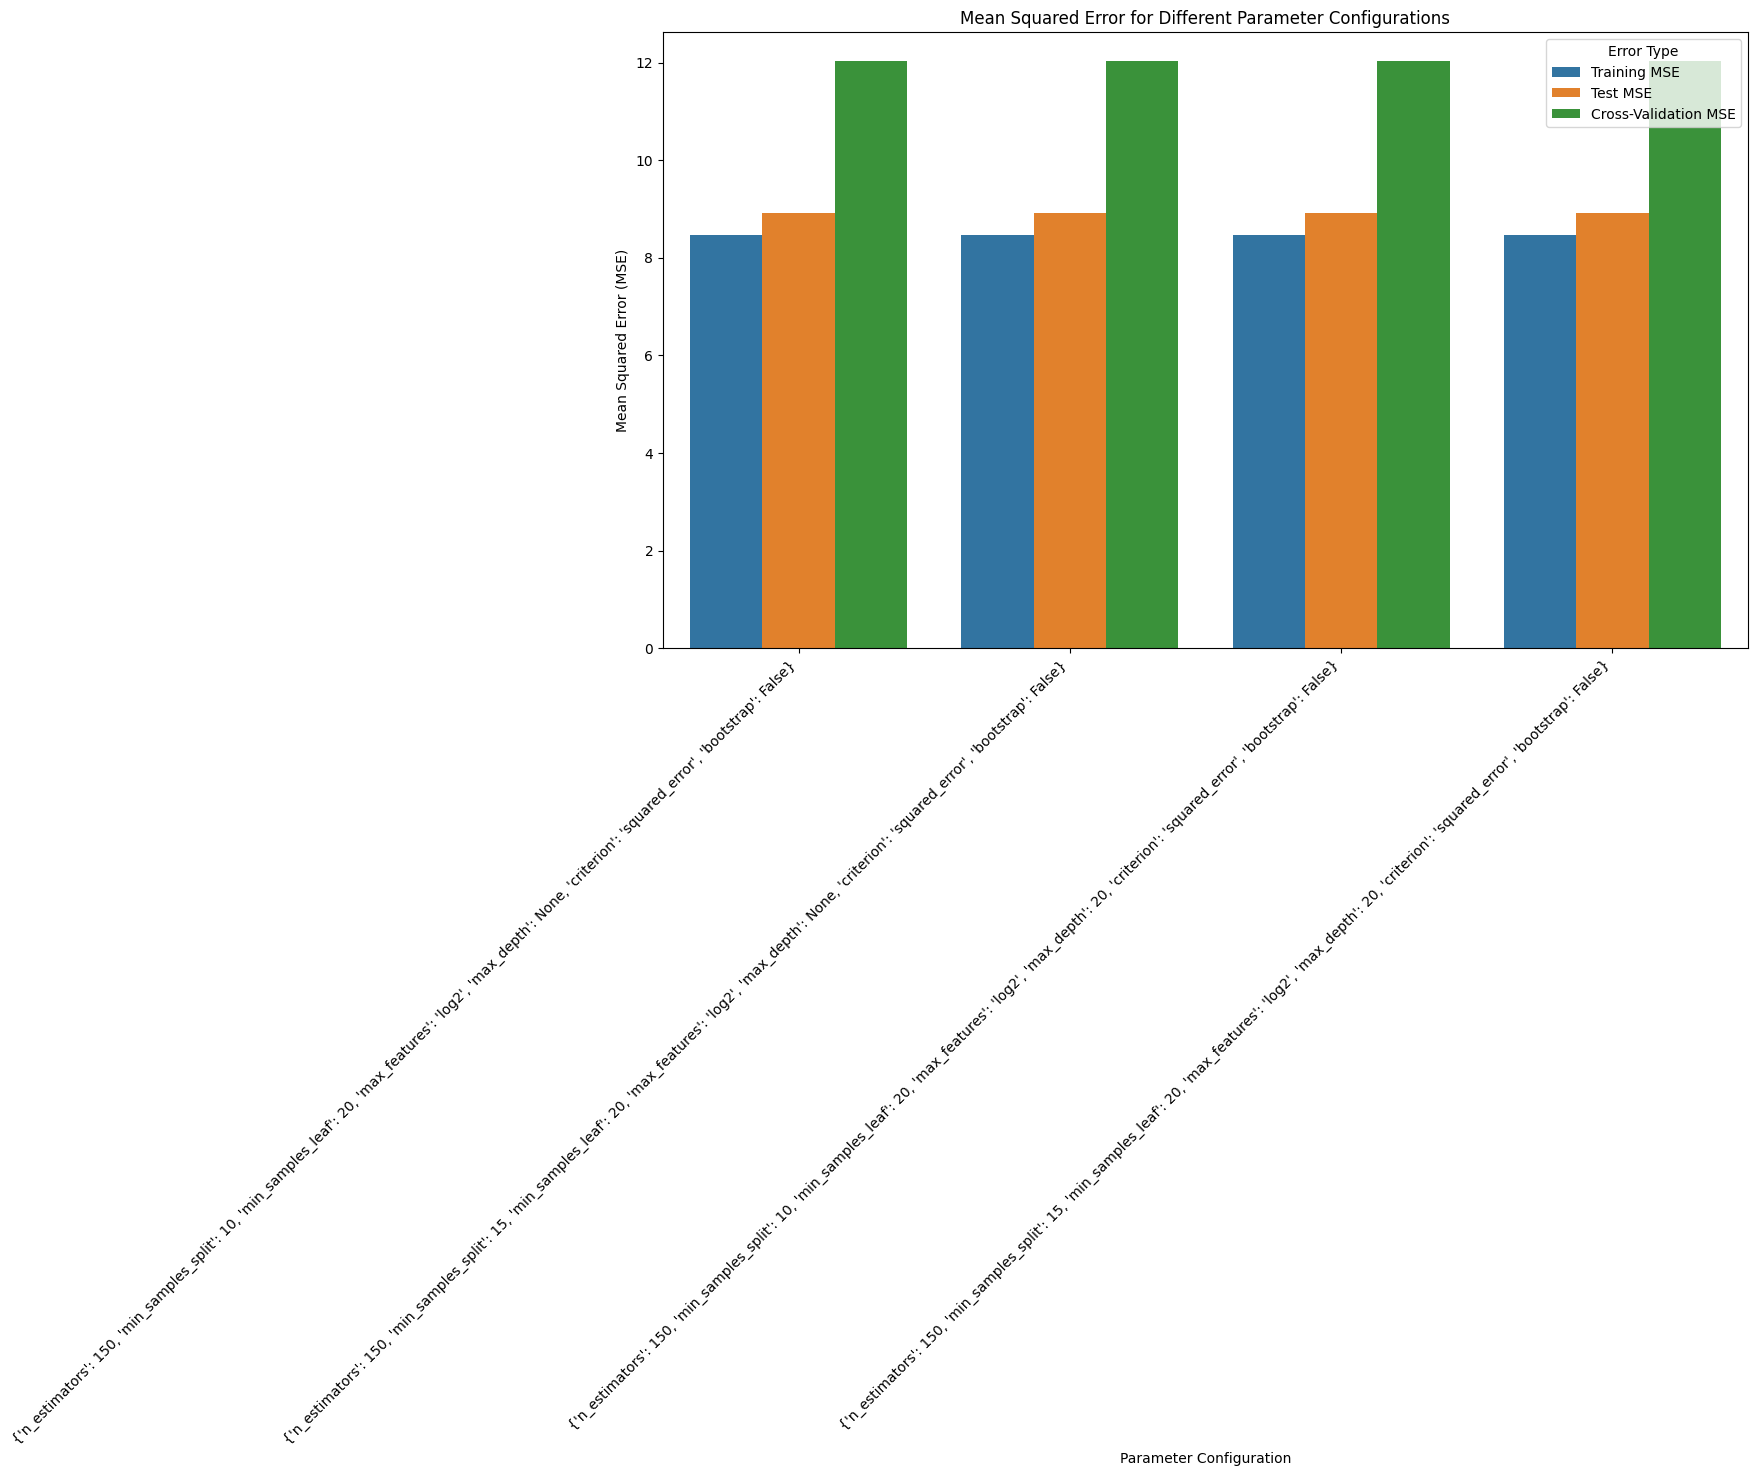

<ipython-input-21-ba1e8a0f7d94>:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


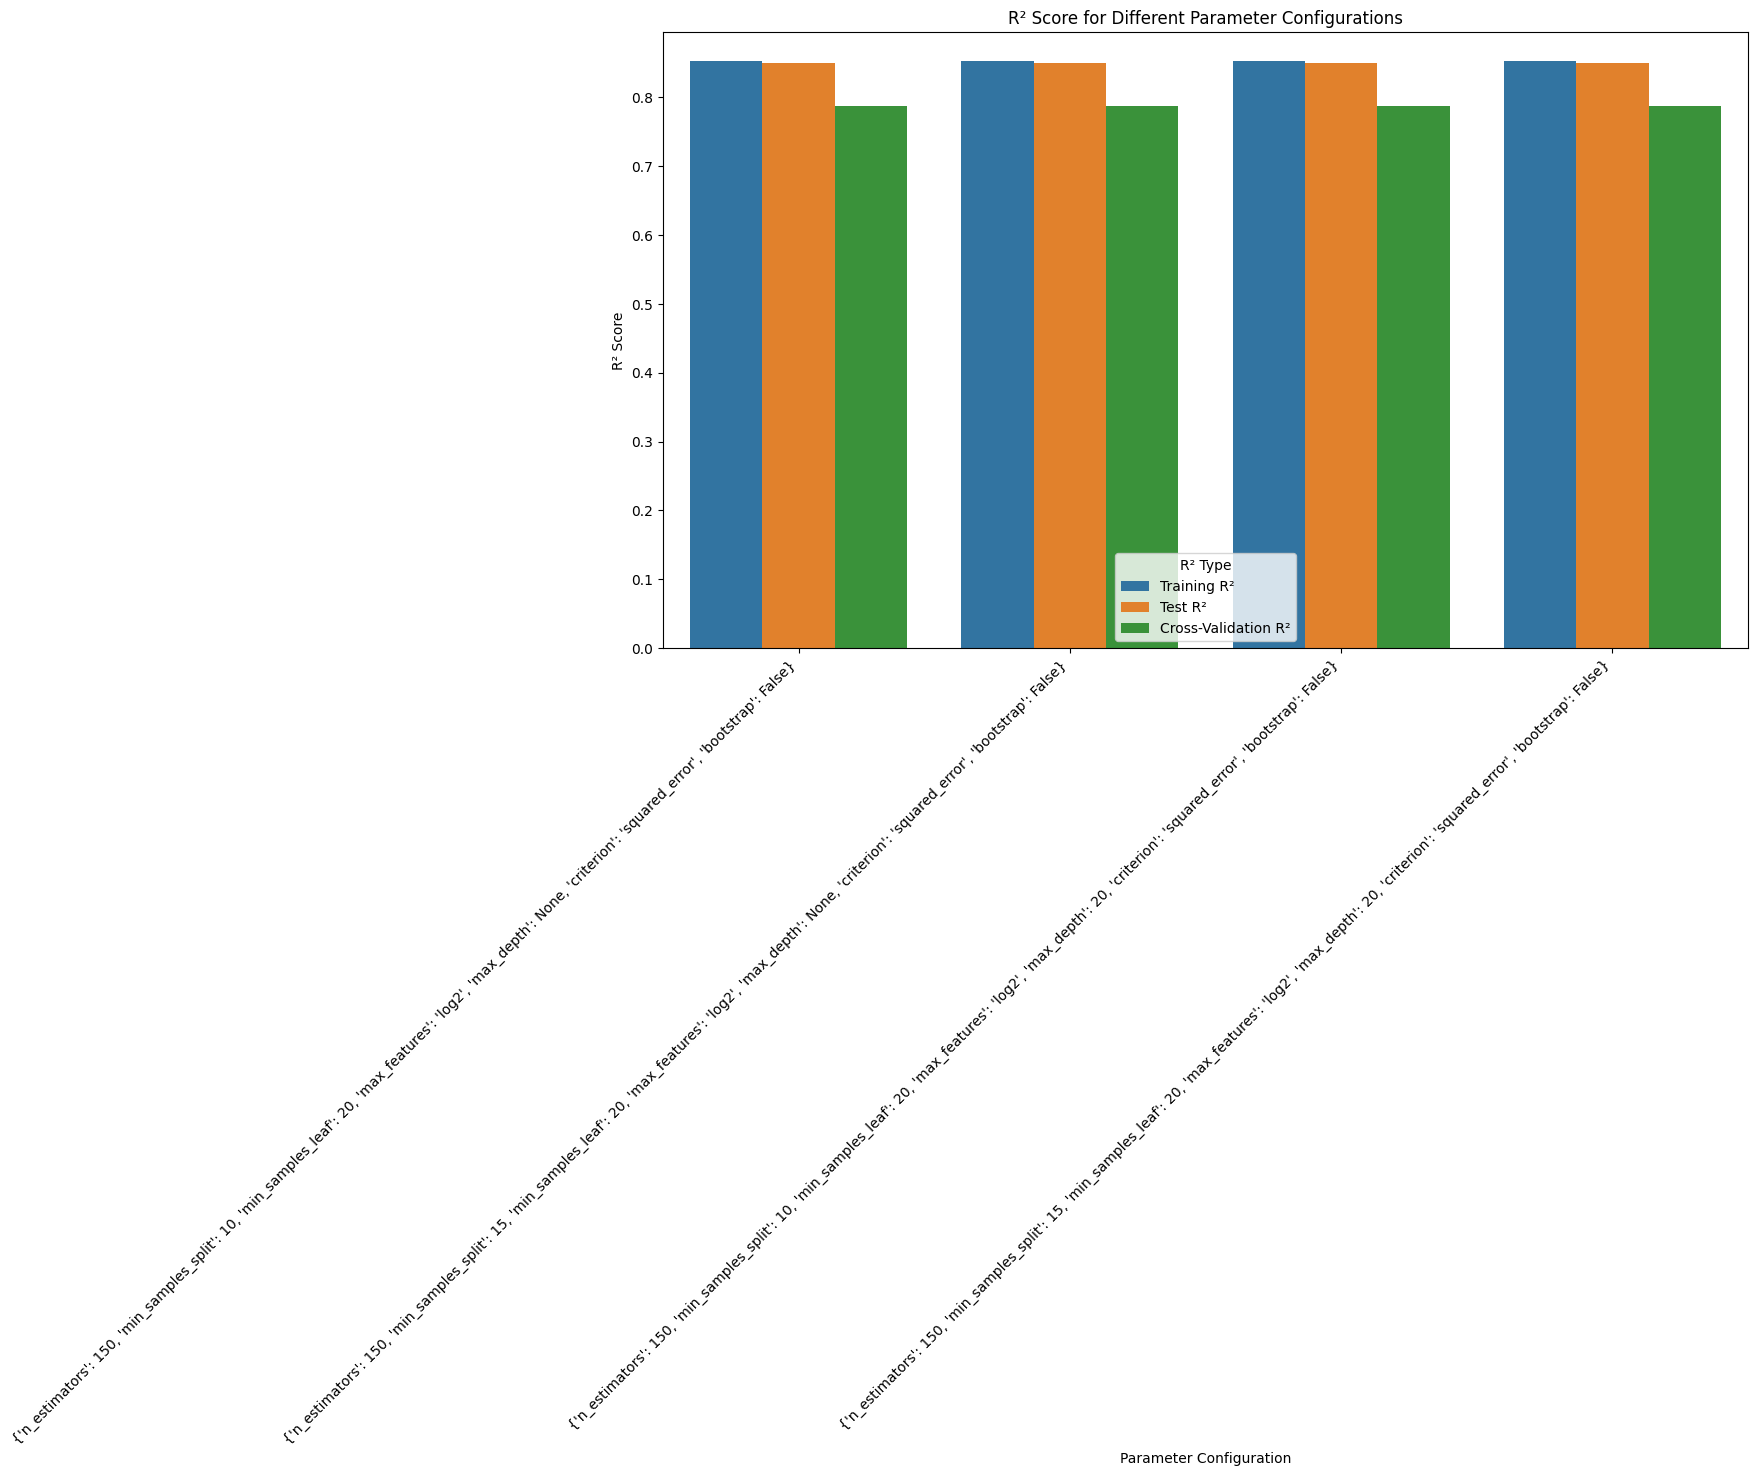

Mean Squared Error Results:
                                          Parameters  Training MSE  Test MSE  \
0  {'n_estimators': 150, 'min_samples_split': 10,...      8.465683   8.90888   
1  {'n_estimators': 150, 'min_samples_split': 15,...      8.465683   8.90888   
2  {'n_estimators': 150, 'min_samples_split': 10,...      8.465683   8.90888   
3  {'n_estimators': 150, 'min_samples_split': 15,...      8.465683   8.90888   

   Cross-Validation MSE  
0             12.023692  
1             12.023692  
2             12.023692  
3             12.023692  

R² Score Results:
                                          Parameters  Training R²   Test R²  \
0  {'n_estimators': 150, 'min_samples_split': 10,...      0.85203  0.850393   
1  {'n_estimators': 150, 'min_samples_split': 15,...      0.85203  0.850393   
2  {'n_estimators': 150, 'min_samples_split': 10,...      0.85203  0.850393   
3  {'n_estimators': 150, 'min_samples_split': 15,...      0.85203  0.850393   

   Cross-Validation R²  
0

In [21]:
# Initialize lists to store the errors
train_errors = []
test_errors = []
cv_errors = []
train_r2_scores = []
test_r2_scores = []
cv_r2_scores = []

# Iterate through the best models
for model in random_search.cv_results_['params']:
    # Fit the model with the specific parameters
    rf = RandomForestRegressor(random_state=42, **model)
    rf.fit(X_train_scaled, y_train)

    # Training error
    y_train_pred = rf.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Test error
    y_test_pred = rf.predict(X_test_scaled)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Cross-validation error
    cv_mse = -cross_val_score(rf, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    cv_r2 = cross_val_score(rf, X_train_scaled, y_train, scoring='r2', cv=5).mean()

    # Append errors to the lists
    train_errors.append(mse_train)
    test_errors.append(mse_test)
    cv_errors.append(cv_mse)
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)
    cv_r2_scores.append(cv_r2)

# Create a DataFrame for MSE results
mse_df = pd.DataFrame({
    'Parameters': [str(params) for params in random_search.cv_results_['params']],
    'Training MSE': train_errors,
    'Test MSE': test_errors,
    'Cross-Validation MSE': cv_errors
})

# Melt the DataFrame for seaborn
melted_mse_df = mse_df.melt(id_vars='Parameters',
                             value_vars=['Training MSE', 'Test MSE', 'Cross-Validation MSE'],
                             var_name='Error Type', value_name='MSE')

# Plotting MSE
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_mse_df, x='Parameters', y='MSE', hue='Error Type')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Squared Error for Different Parameter Configurations')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Parameter Configuration')
plt.legend(title='Error Type')
plt.tight_layout()
plt.show()

# Create a DataFrame for R² results
r2_df = pd.DataFrame({
    'Parameters': [str(params) for params in random_search.cv_results_['params']],
    'Training R²': train_r2_scores,
    'Test R²': test_r2_scores,
    'Cross-Validation R²': cv_r2_scores
})

# Melt the DataFrame for seaborn
melted_r2_df = r2_df.melt(id_vars='Parameters',
                           value_vars=['Training R²', 'Test R²', 'Cross-Validation R²'],
                           var_name='R² Type', value_name='R² Score')

# Plotting R²
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_r2_df, x='Parameters', y='R² Score', hue='R² Type')
plt.xticks(rotation=45, ha='right')
plt.title('R² Score for Different Parameter Configurations')
plt.ylabel('R² Score')
plt.xlabel('Parameter Configuration')
plt.legend(title='R² Type')
plt.tight_layout()
plt.show()

print("Mean Squared Error Results:")
print(mse_df)

print("\nR² Score Results:")
print(r2_df)

In [22]:
# Define a threshold for similarity
similarity_threshold = 3.1

# List to store similar parameter configurations
similar_parameters = []

# Check for each parameter configuration if the errors are similar
for i, params in enumerate(random_search.cv_results_['params']):
    train_mse = train_errors[i]
    test_mse = test_errors[i]
    cv_mse = cv_errors[i]

    # Check if the errors are approximately similar
    if (abs(train_mse - test_mse) <= similarity_threshold and
        abs(train_mse - cv_mse) <= similarity_threshold and
        abs(test_mse - cv_mse) <= similarity_threshold):
        similar_parameters.append((params, train_mse, test_mse, cv_mse))

if similar_parameters:
    print("Similar parameter configurations with their errors:")
    for params, train_mse, test_mse, cv_mse in similar_parameters:
        print(f"Parameters: {params}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Cross-Validation MSE: {cv_mse:.4f}")
else:
    print("No parameter configurations found with approximately similar errors.")


No parameter configurations found with approximately similar errors.


# **9. Model Implementation**

In [23]:
# Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)

# Random Forest Model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

## 9.1. Fitting the model with selected parameters

In [24]:
# Initialize the Random Forest model with configuration
random_forest_model = RandomForestRegressor(
    n_estimators=150,
    min_samples_split=10,
    min_samples_leaf=20,
    max_features='log2',
    max_depth=20,
    criterion='squared_error',
    bootstrap=False
)

# Train the model
random_forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      min_samples_leaf=20, min_samples_split=10,
                      n_estimators=150)

# **10. Cross-Validation**

In [25]:
# Linear Regression Cross-Validation
linear_reg_cv_scores = cross_val_score(linear_reg_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
linear_reg_cv_mse = -linear_reg_cv_scores
linear_reg_cv_r2 = cross_val_score(linear_reg_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Random Forest Cross-Validation
random_forest_cv_scores = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
random_forest_cv_mse = -random_forest_cv_scores
random_forest_cv_r2 = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("Linear Regression - Cross-Validation MSE:", np.mean(linear_reg_cv_mse))
print("Linear Regression - Cross-Validation R²:", np.mean(linear_reg_cv_r2))

print("\nRandom Forest - Cross-Validation MSE:", np.mean(random_forest_cv_mse))
print("Random Forest - Cross-Validation R²:", np.mean(random_forest_cv_r2))


Linear Regression - Cross-Validation MSE: 9.7691335916876
Linear Regression - Cross-Validation R²: 0.8169971256094888

Random Forest - Cross-Validation MSE: 11.948979200133138
Random Forest - Cross-Validation R²: 0.7859294292389918


# **11. Model Evaluation**

In [26]:
# Linear Regression - Training Set Evaluation
y_train_pred_linear_reg = linear_reg_model.predict(X_train_scaled)
mse_train_linear_reg = mean_squared_error(y_train, y_train_pred_linear_reg)
r2_train_linear_reg = r2_score(y_train, y_train_pred_linear_reg)

# Linear Regression - Cross-Validation Set Evaluation
y_cross_val_pred_linear_reg = linear_reg_model.predict(X_cross_val_scaled)
mse_cross_val_linear_reg = mean_squared_error(y_cross_val, y_cross_val_pred_linear_reg)
r2_cross_val_linear_reg = r2_score(y_cross_val, y_cross_val_pred_linear_reg)

# Linear Regression - Test Set Evaluation
y_test_pred_linear_reg = linear_reg_model.predict(X_test_scaled)
mse_test_linear_reg = mean_squared_error(y_test, y_test_pred_linear_reg)
r2_test_linear_reg = r2_score(y_test, y_test_pred_linear_reg)

# Random Forest - Training Set Evaluation
y_train_pred_rf = random_forest_model.predict(X_train_scaled)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Random Forest - Cross-Validation Set Evaluation
y_cross_val_pred_rf = random_forest_model.predict(X_cross_val_scaled)
mse_cross_val_rf = mean_squared_error(y_cross_val, y_cross_val_pred_rf)
r2_cross_val_rf = r2_score(y_cross_val, y_cross_val_pred_rf)

# Random Forest - Test Set Evaluation
y_test_pred_rf = random_forest_model.predict(X_test_scaled)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print evaluation results for Linear Regression
print("\nLinear Regression - Training Set Evaluation:")
print("MSE:", mse_train_linear_reg)
print("R²:", r2_train_linear_reg)

print("\nLinear Regression - Cross-Validation Set Evaluation:")
print("MSE:", mse_cross_val_linear_reg)
print("R²:", r2_cross_val_linear_reg)

print("\nLinear Regression - Test Set Evaluation:")
print("MSE:", mse_test_linear_reg)
print("R²:", r2_test_linear_reg)

# Print evaluation results for Random Forest
print("\nRandom Forest - Training Set Evaluation:")
print("MSE:", mse_train_rf)
print("R²:", r2_train_rf)

print("\nRandom Forest - Cross-Validation Set Evaluation:")
print("MSE:", mse_cross_val_rf)
print("R²:", r2_cross_val_rf)

print("\nRandom Forest - Test Set Evaluation:")
print("MSE:", mse_test_rf)
print("R²:", r2_test_rf)



Linear Regression - Training Set Evaluation:
MSE: 6.70264474936462
R²: 0.8828457914244022

Linear Regression - Cross-Validation Set Evaluation:
MSE: 9.01917186141618
R²: 0.8425046837083652

Linear Regression - Test Set Evaluation:
MSE: 8.949929221761248
R²: 0.8497035982324391

Random Forest - Training Set Evaluation:
MSE: 8.40619313829576
R²: 0.8530698043717717

Random Forest - Cross-Validation Set Evaluation:
MSE: 10.063603413660372
R²: 0.8242665261265854

Random Forest - Test Set Evaluation:
MSE: 8.826810909631751
R²: 0.8517711273543194


# **12. Results plots**

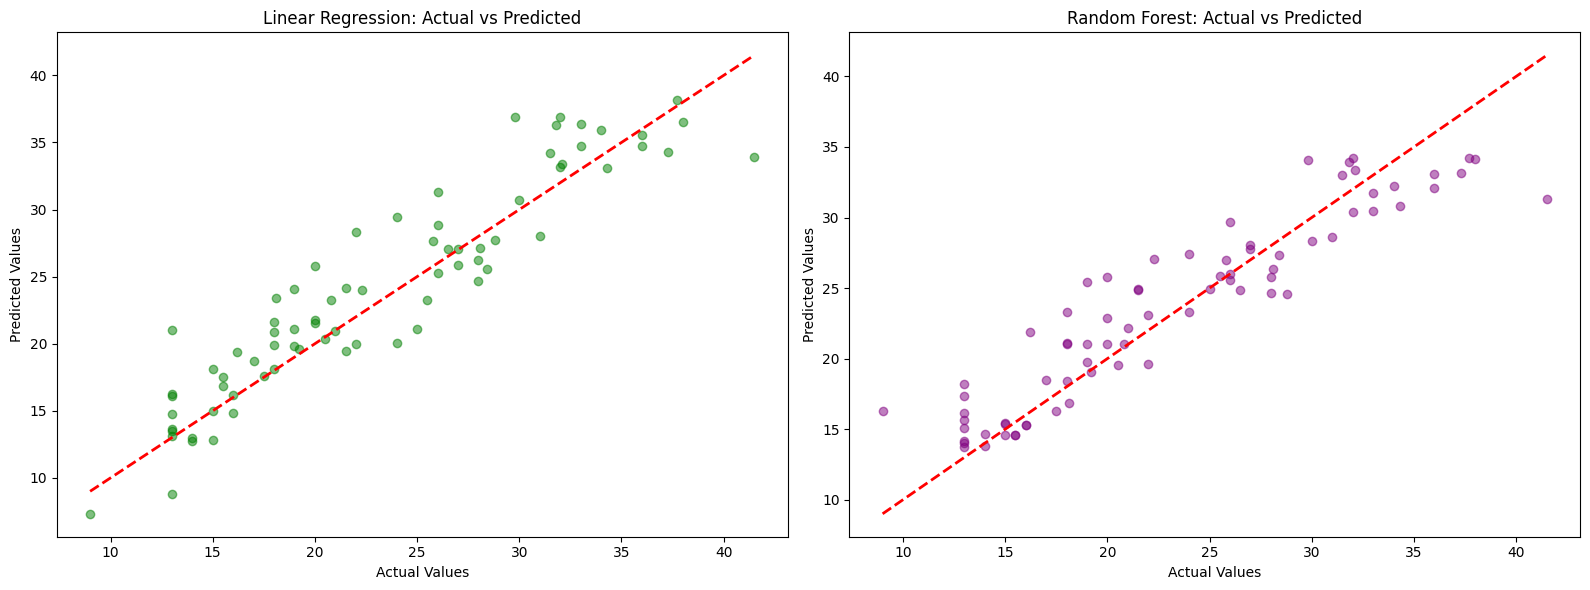

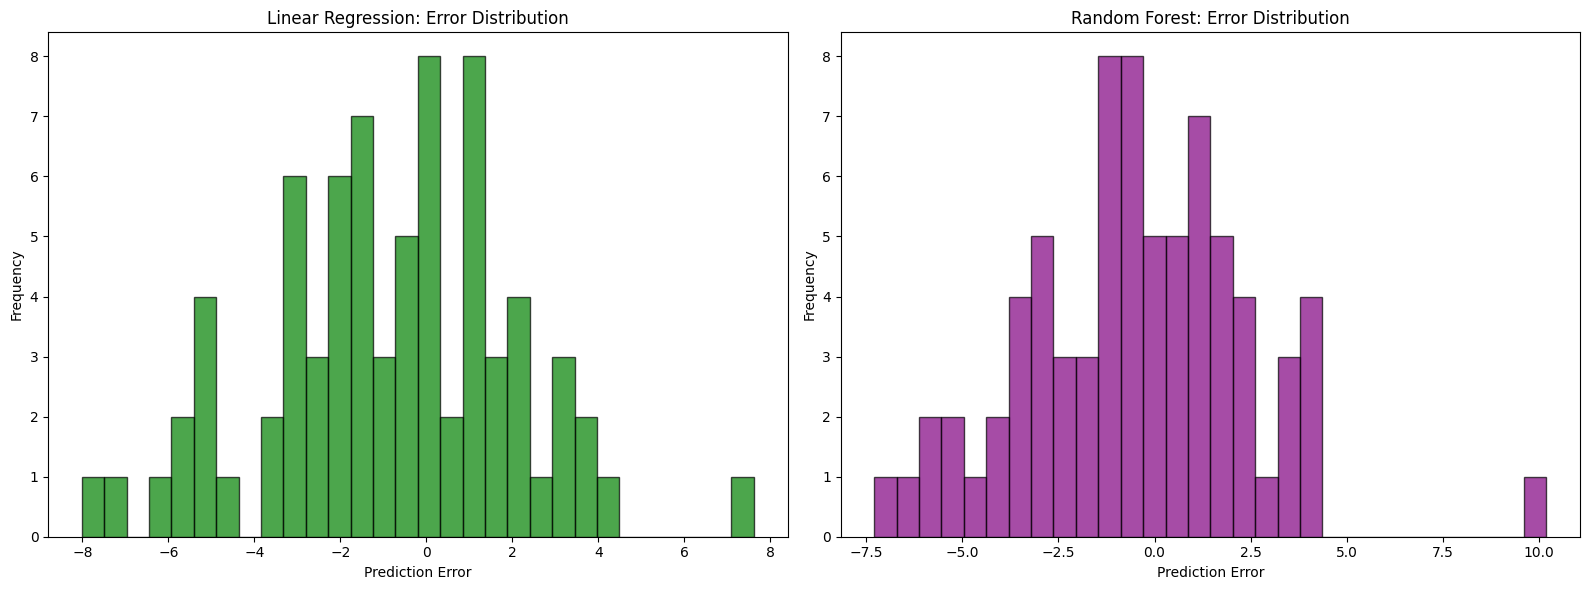

In [27]:
# Generate predictions for Linear Regression and Random Forest
lr_pred_test = linear_reg_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)

# Set up a larger figure for the subplots
plt.figure(figsize=(16, 6))

# Linear Regression: Plotting Actual vs Predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Random Forest: Plotting Actual vs Predicted values
plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred_test, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))

# Linear Regression: Plotting Error Distribution
plt.subplot(1, 2, 1)
lr_errors = y_test - lr_pred_test
plt.hist(lr_errors, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Linear Regression: Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

# Random Forest: Plotting Error Distribution
plt.subplot(1, 2, 2)
rf_errors = y_test - rf_pred_test
plt.hist(rf_errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Random Forest: Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# **13. Conclusion**

In this project, we implemented and evaluated multiple regression models, including Linear Regression and Random Forest, to predict the mpg (miles per gallon) of cars.

After performing data preprocessing, including handling missing values, outliers, and feature selection, we split the data into training, cross-validation, and test sets, ensuring proper model evaluation.

We identified overfitting in the training data using the Random Forest model, and to address this, we performed several feature engineering steps to make the most out of the data while avoiding overfitting.

Next, we tuned the hyperparameters and selected the best model through hyperparameter tuning and evaluation.

Finally, we implemented, cross-validated, and evaluated the trained machine learning models to assess their performance.

### Final Features Defining mpg of a Car:

1. **Original Features:**
   * **Horsepower:** The engine power of the car.
   * **Weight:** The weight of the car.
   * **Displacement:** Engine displacement, related to engine size.
   * **Acceleration:** Time it takes for the car to accelerate (from 0 to 60 mph).
   * **Model Year:** Year of manufacturing of the car.
   * **Cylinders:** Number of cylinders in the car’s engine.
   * **Origin:** Country of origin (encoded as one-hot features).

2. **New Features Created During Feature Engineering:**
   * **power_to_weight:** Ratio of horsepower to weight, representing engine power relative to the car's mass.
   * **displacement_to_hp:** Ratio of displacement to horsepower, indicating how the engine size compares to power.
   * **acceleration_per_weight:** Acceleration rate per unit of weight, showing how the car's acceleration is influenced by its weight.
   * **age:** Age of the car (calculated as 2024 - model year), which can affect fuel efficiency as cars age.
   * **log_horsepower:** Log-transformed horsepower, possibly to normalize the distribution of the horsepower feature.
   * **log_weight:** Log-transformed weight, which helps in reducing the impact of large values in weight.
   * **displacement_to_weight:** Ratio of displacement to weight, indicating engine size relative to the car’s mass.
   * **horsepower_to_cylinders:** Ratio of horsepower to the number of cylinders, showing engine power efficiency relative to the number of cylinders.
   * **hp_to_acceleration:** Ratio of horsepower to acceleration, which may correlate with how engine power impacts acceleration.
   * **weight_to_acceleration:** Ratio of car weight to acceleration, reflecting the effect of weight on performance.
   * **hp_bins:** Binned categories for horsepower, reflecting different levels of engine power (Very Low, Low, Medium, High, Very High).
   * **weight_bins:** Binned categories for weight, reflecting different weight categories (Light, Medium, Heavy, Very Heavy).
   * **year_diff:** Difference between the car’s model year and the median year in the dataset, which might capture trends over time.

3. **One-Hot Encoded Features:**
   * **origin:** Encoded as one-hot features, representing the origin of the car (e.g., origin_USA, origin_Europe).
   * **hp_bins:** One-hot encoded categories for horsepower bins.
   * **weight_bins:** One-hot encoded categories for weight bins.

Having an R² value higher than 80% for all the split datasets, we can conclude that the Random Forest and Linear Regression models we implemented to predict the mpg of a car are very accurate.
